In [1]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import os, urllib.request, json
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
api_key = '8NIVU9H2J3EKJNU2'

data_download_page:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Note:
Most of the data files I manually downloaded from Yahoo Finance

In [2]:
!ls ../data

birth_weight.csv      images				    mnist
fashion_mnist.tar.xz  international-airline-passengers.csv  stocks


In [3]:
#KO_df = pd.read_csv(os.path.join('../data','KO.csv'),delimiter=',',parse_dates=['Date'],infer_datetime_format=True).set_index('Date',drop=False)
#C_df = pd.read_csv(os.path.join('../data','C.csv'),delimiter=',',parse_dates=['Date'],infer_datetime_format=True).set_index('Date',drop=False)
CAT_df = pd.read_csv(os.path.join('../data/stocks','CAT.csv'),delimiter=',',parse_dates=['Date'],infer_datetime_format=True).set_index('Date',drop=False)

In [4]:
CAT_df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [5]:
CAT_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1962-01-02,1962-01-02,1.604167,1.619792,1.588542,1.604167,0.143606,163200
1962-01-03,1962-01-03,1.604167,1.619792,1.588542,1.619792,0.145005,156000
1962-01-04,1962-01-04,1.656250,1.708333,1.656250,1.661458,0.148735,355200
1962-01-05,1962-01-05,1.661458,1.697917,1.656250,1.677083,0.150134,163200
1962-01-08,1962-01-08,1.677083,1.703125,1.666667,1.687500,0.151066,204000


In [6]:
CAT_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-06-29,2018-06-29,136.610001,137.850006,135.580002,135.669998,135.669998,4107900
2018-07-02,2018-07-02,133.800003,136.429993,133.199997,136.289993,136.289993,3172600
2018-07-03,2018-07-03,137.000000,137.350006,133.330002,133.830002,133.830002,1837400
2018-07-05,2018-07-05,135.009995,136.089996,134.089996,135.809998,135.809998,3366300
2018-07-06,2018-07-06,135.110001,135.860001,133.320007,135.410004,135.410004,3179600


In [7]:
CAT_df.index[len(CAT_df)-1]

Timestamp('2018-07-06 00:00:00')

In [8]:
def plot_df(df):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(figsize=(18,9))
    ax.plot(df.index, df['Adj Close'])

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(df.index[0], 'Y')
    datemax = np.datetime64(df.index[len(df)-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = df['Adj Close']
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate(rotation=45)

    plt.show()

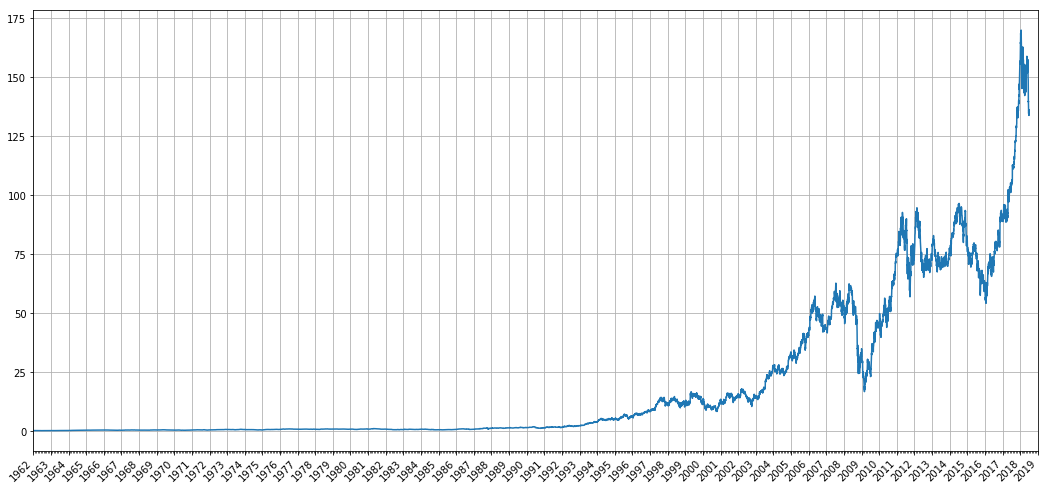

In [9]:
plot_df(CAT_df)

In [10]:
CAT_short = CAT_df['2003':]
CAT_short.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2003-01-02,2003-01-02,22.975000,23.875000,22.885,23.875000,14.885233,4539400
2003-01-03,2003-01-03,23.825001,23.850000,23.500,23.715000,14.785481,3399800
2003-01-06,2003-01-06,23.775000,24.209999,23.775,24.200001,15.087860,2354400
2003-01-07,2003-01-07,24.200001,24.200001,23.650,23.924999,14.916405,3126000
2003-01-08,2003-01-08,23.930000,23.930000,23.125,23.200001,14.464391,3246600


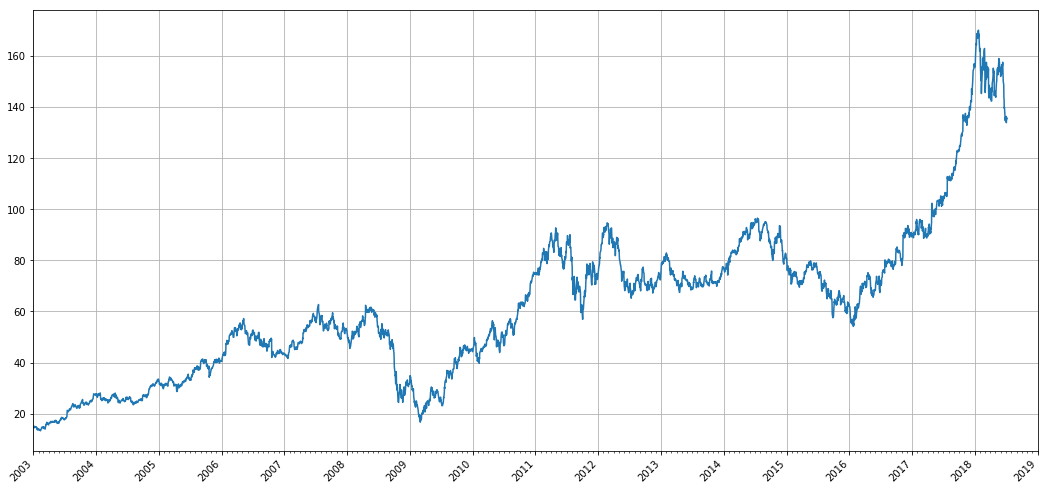

In [11]:
plot_df(CAT_short)

### Split into Training and Test set

In [12]:
# Get the primary data we're working with in the right format
CAT_prices = np.array(CAT_df['Adj Close'])

In [13]:
len(CAT_prices)

14226

In [14]:
train_data = CAT_prices[:11500]
test_data = CAT_prices[11500:]

### Normalizing the Data
Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape `[data_size, num_features]`.

In [15]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

As different time windows of data have different value ranges, we normalize the data by splitting the full series into windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.

Tip: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue

In [16]:
# Train the Scaler with training data and smooth data
window_size = 2500 # changed from 2500
for di in range(0,10000,window_size):
    scaler.fit(train_data[di:di+window_size,:])
    train_data[di:di+window_size,:] = scaler.transform(train_data[di:di+window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+window_size:,:])
train_data[di+window_size:,:] = scaler.transform(train_data[di+window_size:,:])

Reshape the data back to the shape of `[data_size]`

In [17]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

You can now smooth the data using an exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [18]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11500):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_data = np.concatenate([train_data,test_data],axis=0)

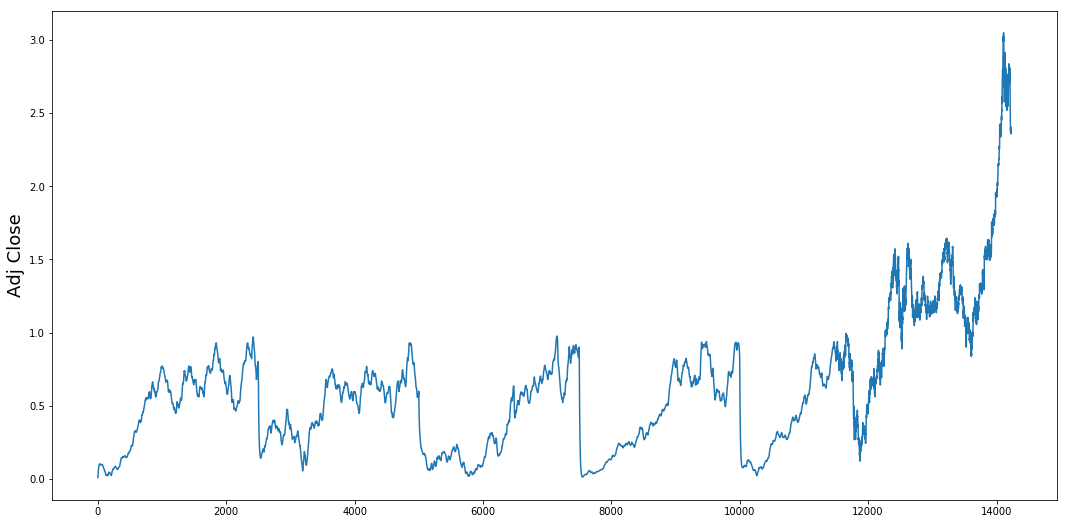

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(all_data.shape[0]),all_data)
plt.ylabel('Adj Close',fontsize=18)
plt.show()

### One-Step Ahead Prediction via Averaging

* First you will try to predict the future stock market prices (for example, xt+1) as an average of the previously observed stock market prices within a fixed size window (for example, $x_{t-N}, ..., x_t) (say previous 100 days). 
* In other words, you say the prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N.

In [20]:
df = CAT_df
df['date_index']=range(len(CAT_df))

In [21]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00493


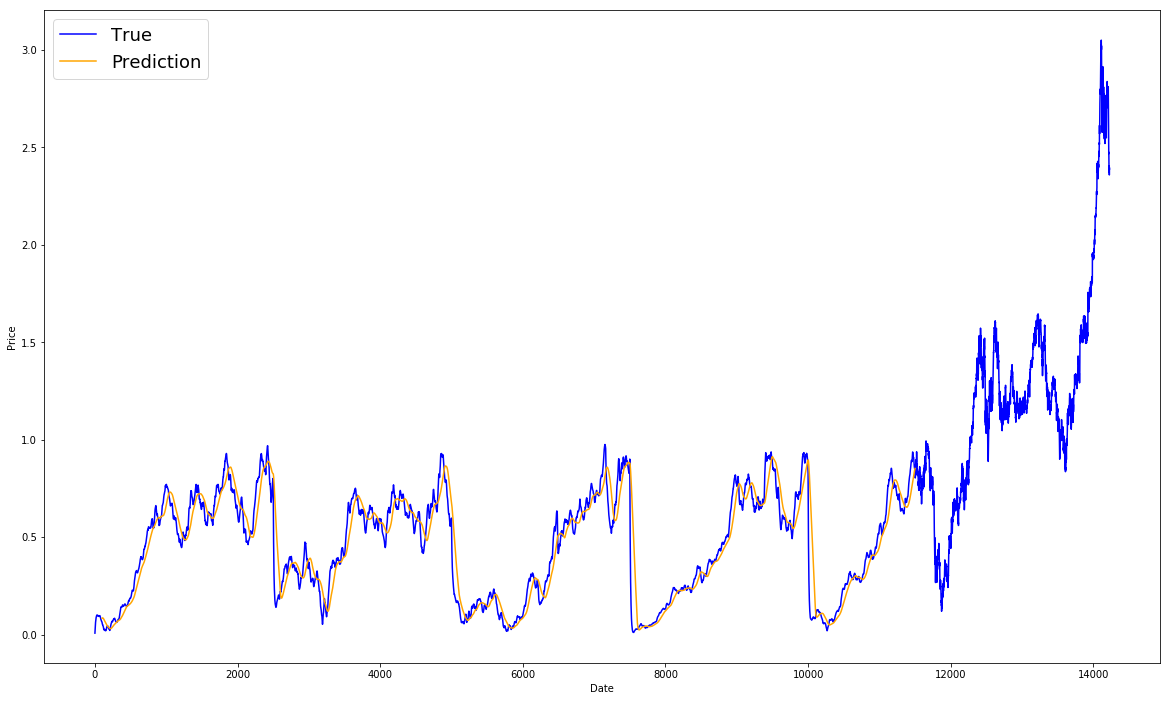

In [22]:
plt.figure(figsize = (20,12))
plt.plot(range(df.shape[0]),all_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.show()

So what do the above graphs (and the MSE) say?

The model is basically saying that prices should be near their recent average, so for very short predictions (one day ahead), the MSE should be ok, given that stock prices don't change from 0 to 100 overnight.

In [23]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


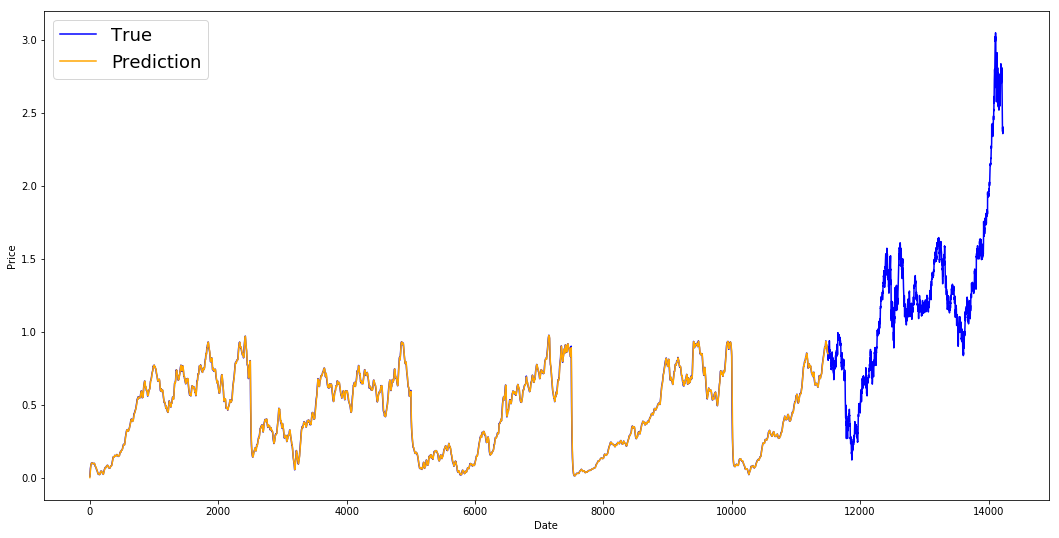

In [24]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.show()

### Predictions using an LSTM

### Data Generator
You are first going to implement a data generator to train your model. This data generator will have a method called `.unroll_batches(...)` which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size `[batch_size, 1]`. Then each batch of input data will have a corresponding output batch of data.

For example if `num_unrollings=3` and `batch_size=4` a set of unrolled batches might look like:

input data: 
$[x_0,x_10,x_20,x_30],[x_1,x_11,x_21,x_31],[x_2,x_12,x_22,x_32]$

output data: 
$[x_1,x_11,x_21,x_31],[x_2,x_12,x_22,x_32],[x_3,x_13,x_23,x_33]$

### Data Augmentation
* To make our model more robust, we will not _always_ make the output for $x_t$ $x_{t+1}$. * Instead, you will randomly sample an output from the set $x_{t+1},x_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size.

Here you are making the following assumption:

$x_{t+1},x_{t+2},\ldots,x_{t+N}$ will not be very far from each other, which, under normal market conditions should be a reasonable assumption for stock movement predictions.

#### Illustration of how a batch of data is created:
<img src='../pics/batch_pno02e.webp'>

In [25]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [26]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00793198 0.8086585  0.4279747  0.7011874  0.75672734]

	Output: [0.03034962 0.8086585  0.4279747  0.6985535  0.7595539 ]


Unrolled index 1
	Inputs:  [0.01542077 0.80799055 0.4249045  0.70056635 0.76129526]

	Output: [0.03034962 0.8094197  0.42363638 0.70056635 0.76129526]


Unrolled index 2
	Inputs:  [0.02309385 0.8068155  0.42323226 0.6985535  0.75863165]

	Output: [0.03711299 0.80748    0.4172664  0.69549584 0.760451  ]


Unrolled index 3
	Inputs:  [0.03034962 0.80748    0.42363638 0.69549584 0.75911707]

	Output: [0.03034962 0.8106846  0.4207001  0.6847128  0.7604521 ]


Unrolled index 4
	Inputs:  [0.03711299 0.8086519  0.42481828 0.69253623 0.7595539 ]

	Output: [0.05932694 0.8195345  0.42481828 0.69253623 0.7540033 ]


### Defining Hyperparameters
In this section, you'll define several hyperparameters. $D$ is the dimensionality of the input. It's straightforward, as you take the previous stock price as the input and predict the next one, which should be 1.

Then you have `num_unrollings`, which is a hyperparameter related to the backpropagation through time (BPTT) that is used to optimize the LSTM model. This denotes how many continuous time steps you consider for a single optimization step. You can think of this as, instead of optimizing the model by looking at a single time step, you optimize the network by looking at `num_unrollings` time steps. The larger the better (well... maybe?).

Then you have the `batch_size`. Batch size is how many data samples you consider in a single time step.

Next you define `num_nodes` which represents the number of hidden neurons in each cell. You can see that there are three layers of LSTMs in this example.

In [27]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

### Defining Inputs and Outputs
* Define placeholders for training inputs and labels. 
* We have a list of input placeholders, where each placeholder contains a single batch of data. 
* And the list has `num_unrollings` placeholders, that will be used at once for a single optimization step.

In [28]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

### Defining the Parameters of the LSTM and Regression layer
* We have a three-layer of LSTMs and a linear regression layer, denoted by w and b, that takes the output of the last Long Short-Term Memory cell and outputs the prediction for the next time step. 
* You can use the MultiRNNCell in TensorFlow to encapsulate the three LSTMCell objects you created. 
* We will also use dropout implemented in the LSTM cells.

In [30]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-29-c24fa21357f4>", line 14, in <module>
    w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


### Calculating LSTM output and Feeding it to the regression layer to get final prediction
* We now create TensorFlow variables ($c$ and $h$) that will hold the cell state and the hidden state of the LSTM cell. 
* Then we transform the list of `train_inputs` to have a shape of `[num_unrollings, batch_size, D]`
* This is needed for calculating the outputs with the `tf.nn.dynamic_rnn` function. 
* You then calculate the LSTM outputs with the `tf.nn.dynamic_rnn` function and split the output back to a list of `num_unrolling` tensors. 

In [31]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []

for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transformations, because the function dynamic_rnn requires 
# the output to be of a specific format. 
# Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

### Loss Calculation and Optimizer
* Note that calculating the loss for RNNs is slightly different. 
* For each batch of predictions and true outputs, you calculate the Mean Squared Error. 
* Then we sum (not average) all these mean squared losses together. 
* Finally, you define the optimizer you're going to use to optimize the neural network. 

In [32]:
# When calculating the loss you need to be careful about the exact form, 
# because you calculate loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that 
# over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


### Prediction Related Calculations
* First, define a placeholder for feeding in the input (sample_inputs).
* Then, similar to the training stage, you define state variables for prediction (sample_c and sample_h). 
* Finally you calculate the prediction with the `tf.nn.dynamic_rnn` function and then send the output through the regression layer ($w$ and $b$). 
* You also should define the `reset_sample_state` operation, which resets the cell state and the hidden state. You should execute this operation at the start, every time you make a sequence of predictions.

In [33]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


### Running the LSTM
Here we train and predict stock price movements for several epochs and see whether the predictions get better or worse over time. 

* First define a test set of starting points (`test_points_seq`) on the time series to evaluate the model on
* Then for each epoch:
    * For full sequence length of training data
        * Unroll a set of num_unrollings batches
        * Train the neural network with the unrolled batches
    * Calculate the average training loss
    * For each starting point in the test set
        * Update the LSTM state by iterating through the previous num_unrollings data points found before the test point
        * Make predictions for n_predict_once steps continuously, using the previous prediction as the current input
        * Calculate the MSE loss between the `n_predict_once` points predicted and the true stock prices at those time stamps

### Some Memory Management
* Note to self: TF dev branch may run out of memory - downgrade to TF v1.8

In [34]:
del df
del CAT_df
import gc
gc.collect()
print("cleaned memory")

cleaned memory


In [ ]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 150 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediction as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')
session.close()

In [ ]:
session.close()

### Visualizing the Predictions
You can see how the MSE loss is going down with the amount of training. This is good sign that the model is learning something useful. To quantify your findings, you can compare the network's MSE loss to the MSE loss you obtained when doing the standard averaging (0.004). You can see that the LSTM is doing better than the standard averaging. And you know that standard averaging (though not perfect) followed the true stock prices movements reasonably.

In [ ]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(all_data.shape[0]),all_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.2
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(all_data.shape[0]),all_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()